In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [3]:
# import mc data file
# mcfile = 'mc_data/mc_data_trial5.npy'
mcfile = 'mc_data/testing.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'dsa', 'unxsec'])


In [5]:
mc_df

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,dsa,unxsec
0,10000.0,6.678731,0.008262,0.238205,6.237846,0.291473,0.539890,5.058866,1.629358,10991.928495,5.212896e+04
1,10000.0,8.385133,0.007309,0.314935,8.816463,0.280292,0.961932,2.385799,6.246774,383.470396,4.051783e+03
2,10000.0,8.070826,0.007625,0.561751,2.545884,0.613878,0.854234,4.422278,2.128444,261878.623585,1.087455e+06
3,10000.0,6.429779,0.006081,0.940853,7.006317,0.623913,0.679805,3.279790,3.628794,6700.667897,7.438211e+04
4,10000.0,6.570704,0.006418,0.420982,3.475427,0.446099,0.672718,5.475285,2.434093,397764.751111,1.760236e+06
...,...,...,...,...,...,...,...,...,...,...,...
995,10000.0,7.285968,0.006101,0.902130,5.698607,0.733532,0.870165,3.045606,5.070619,18543.726600,1.162522e+05
996,10000.0,6.331418,0.006589,0.481540,8.451327,0.368261,0.608410,4.347546,4.721837,617.474883,1.228034e+04
997,10000.0,7.384762,0.005776,0.766556,6.474414,0.303972,0.944184,4.314531,1.032879,7046.217890,4.973434e+04
998,10000.0,7.774193,0.006604,0.852800,5.588989,0.765656,0.915185,3.892514,4.622723,21108.495190,9.406777e+04


In [27]:
# function to plot histograms

def plot_histogram(df, plot_q, constraints={}, vary_q=None, **options):

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [5, 1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width)
    # print(bins)

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]


    # make plot data
    if vary_q:
        var, values = list(vary_q.items())[0]
        for value in values:
            vfixed_df = fixed_df[fixed_df[var].between(value*0.99, value*1.01)] # default here is requested value is within 1%
            
            counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins, weights=vfixed_df['unxsec'])
            # counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins)
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
            bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
            errors = np.sqrt(counts) # poisson error
            
            ax.errorbar(
                bin_centers, counts, yerr=errors, xerr=bin_widths,
                fmt=options.get('fmt', 'o'), label=options.get('label', fr'${var} = {value}\pm{value*0.01}$'), capsize=3, elinewidth=1, capthick=1
            )
        ax.legend()
            
    else: 
        counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['unxsec'])
        # counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins)
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
        bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
        errors = np.sqrt(counts) # poisson error
        
        ax.errorbar(
            bin_centers, counts, yerr=errors, xerr=bin_widths,
            fmt=options.get('fmt', 'o'), label=options.get('label', ''), capsize=3, elinewidth=1, capthick=1
        )

    # make info box for constraints
    info_text = 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'${var}: [{low}, {high}]$'+'\n'
    ax_info.text(
        -0.3, 0.85, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3)
    )
    ax_info.set_axis_off()

    # set plot info
    if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
    if options.get('x_limits'): ax.set_ylim(options.get('x_limits'))
    ax.set_title(options.get('title', f'{plot_q} frequency'))
    ax.set_ylabel(options.get('y_label', 'Frequency'))
    ax.set_xlabel(options.get('x_label', fr'${plot_q}$'))
    ax.set_yscale(options.get('y_scale', 'linear'))
    ax.set_xscale(options.get('x_scale', 'linear'))
    ax.grid(options.get('grid', True)) 



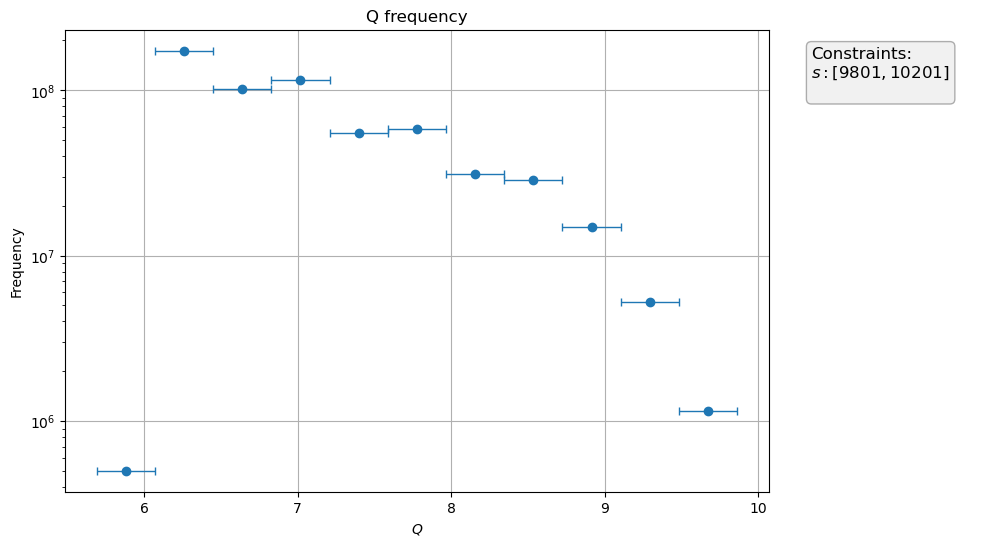

In [41]:
plot_s = 100
delta_s = 1

plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, y_scale='log')
# plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2], 'y':[0.1, 0.9]}, vary_q={'z': [0.2, 0.3, 0.4, 0.5]})
# plot_histogram(mc_df, 'z', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [6, 7, 8, 9]})
# plot_histogram(mc_df, 'phi_kp', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, nbins=10)

